In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader

# For time stamps
from datetime import datetime
from math import sqrt
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

#ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    from keras.models import Sequential
    from keras.layers import Dense, LSTM
    import tensorflow as tf
except:
    !pip install --upgrade tensorflow
    !pip install keras
    !pip install --ignore-installed --upgrade tensorflow-gpu
    !pip install wrapt==1.11.1
    from keras.models import Sequential
    from keras.layers import Dense, LSTM
    import tensorflow as tf

In [3]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import GRU, Dense
import tensorflow as tf

In [4]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [5]:
import yfinance as yf
from datetime import datetime

def collect_data(symbol, start_date):
    end_date = datetime.now().strftime('%Y-%m-%d')
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    return stock_data

# Test the function
df = collect_data('AAPL', '2014-01-01')
print(type(df))


[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>


In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [7]:
df['Returns'] = (df['Close']/df['Close'].shift(1))-1

# Drop the NaN values created by the percentage change
df = df.dropna()
features = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Returns']]
scalar=StandardScaler()
scalar.fit(features)
scaled_data=scalar.transform(features)
pca=PCA(n_components=1)
pca.fit(scaled_data)
x_pca=pca.transform(scaled_data)
pca_columns = ['Principal_Component']  # Customize column names if needed
x_pca_df = pd.DataFrame(x_pca, columns=pca_columns)

In [8]:
def build_training_dataset(input_ds):
    # Create a new dataframe with only the 'Close column 
    input_ds.reset_index()
    data = input_ds.filter(items=['Close'])
    # Convert the dataframe to a numpy array
    dataset = data.values
    # Get the number of rows to train the model on
    training_data_len = int(np.ceil( len(dataset) * .95 ))
    return data, dataset, training_data_len

#Test the function
training_data_df, training_dataset_np, training_data_len = build_training_dataset(df)
dataset=training_dataset_np
data=training_data_df

In [9]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler
def scale_the_data(dataset):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    return scaler, scaled_data

#Test the function
scaler, scaled_data = scale_the_data(training_dataset_np)

In [10]:
def build_training_dataset_pca(input_ds):
    # Create a new dataframe with only the 'Close column 
    input_ds.reset_index()
    data_pca = input_ds.filter(items=['Principal_Component'])
    # Convert the dataframe to a numpy array
    dataset_pca = data.values
    # Get the number of rows to train the model on
    training_pca_data_len = int(np.ceil( len(dataset) * .95 ))
    return dataset_pca, training_pca_data_len

#Test the function
training_pca_dataset_np, training_pca_data_len = build_training_dataset_pca(x_pca_df)

In [11]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler
def scale_the_data(dataset):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    return scaler, scaled_data

#Test the function
scaler_pca, scaled_data_pca = scale_the_data(training_pca_dataset_np)

In [12]:
# Create the training data set 
# Create the scaled training data set
def split_train_dataset(training_data_len):
    train_data = scaled_data_pca[0:int(training_data_len), :]
    # Split the data into x_train and y_train data sets
    x_train = []
    y_train = []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
        if i<= 61:
            #print(x_train)
            #print(y_train)
            print('.')
            
    # Convert the x_train and y_train to numpy arrays 
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    # x_train.shape
    return x_train, y_train

#Test the function
x_train,y_train = split_train_dataset(training_pca_data_len)

.
.


In [13]:
def build_gru_model(x_train, y_train):
    # Build the GRU model
    model = Sequential()
    model.add(GRU(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(GRU(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Train the model
    model.fit(x_train, y_train, batch_size=1, epochs=1)
    return model

# Test the function
gru_model = build_gru_model(x_train, y_train)




2391/2391 [==============================] - 54s 21ms/step - loss: 0.0013


In [14]:
def create_testing_data_set(model, scaler, training_data_len, test_data_len):
    # Create the testing data set
    # Assuming test_data is a 2D array
    test_data = scaled_data[training_data_len - test_data_len:, :]
    # Create the data sets x_test and y_test
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(test_data_len, len(test_data)):
        x_test.append(test_data[i - test_data_len:i, 0])

    # Convert the data to a numpy array
    x_test = np.array(x_test)

    # Reshape the data to match model's expected input shape
    x_test = x_test[:, :60]  # Select the first 60 timesteps

    # Get the models predicted price values
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # Get the root mean squared error (RMSE)
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    return x_test, y_test, predictions, rmse

# Test the function
TEST_DATA_LENGTH = 100
x_test, y_test, predictions, rmse = create_testing_data_set(gru_model, scaler, training_data_len, TEST_DATA_LENGTH)

4/4 [==============================] - 1s 16ms/step


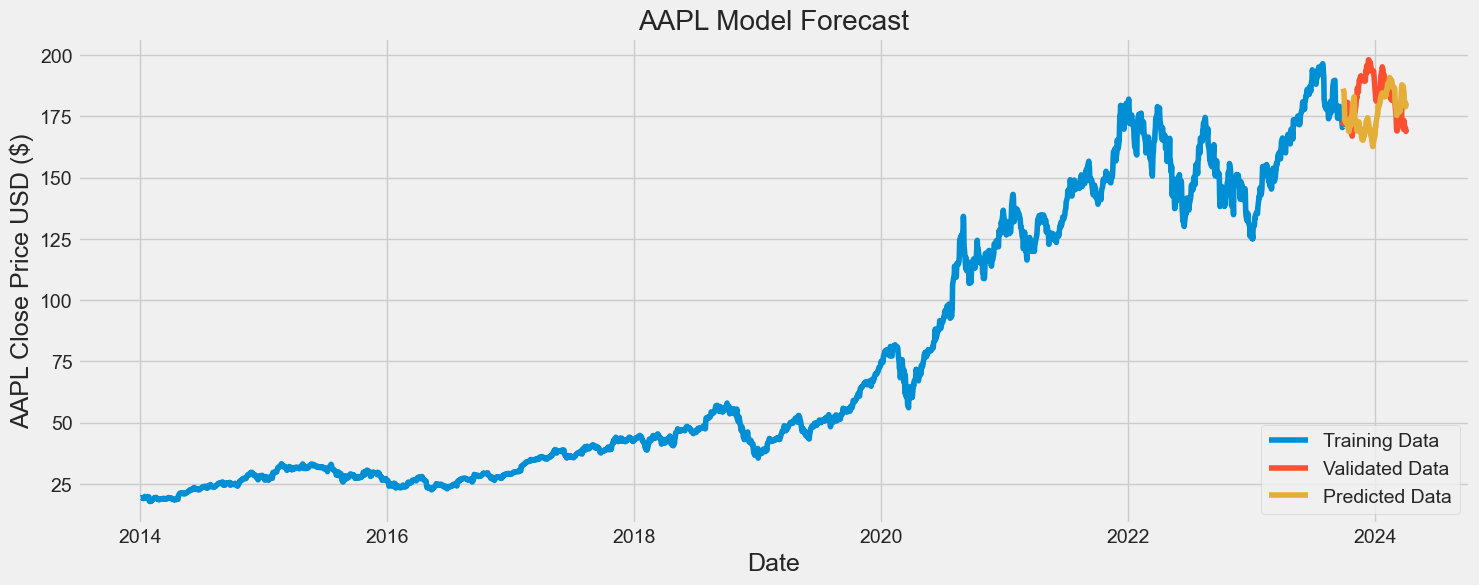

In [15]:
def plot_predictions(stock, data,training_data_len):
    #Plot the data
    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions
    # Visualize the data
    plt.figure(figsize=(16,6))
    title = stock + ' Model Forecast'
    ylabel = stock + ' Close Price USD ($)'
    plt.title(title)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Training Data', 'Validated Data', 'Predicted Data'], loc='lower right')
    plt.show()
    return valid
    
#Test the function
valid = plot_predictions('AAPL',data,training_data_len)

In [16]:
data = x_pca_df

# Split the data into train and test sets (for simplicity, let's assume a 80-20 split)
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Define a function for Time Series Cross-Validation
def time_series_cv(model_type, X_train, y_train, X_test, y_test):
    model = Sequential()
    if model_type == 'LSTM':
        model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    elif model_type == 'GRU':
        model.add(GRU(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Fit the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

    # Make predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Invert predictions to original scale
    train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
    y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
    test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate RMSE
    train_score = np.sqrt(mean_squared_error(y_train, train_predict))
    test_score = np.sqrt(mean_squared_error(y_test, test_predict))

    return train_score, test_score

# Prepare the data for LSTM and GRU models
def prepare_data(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        end_ix = i + n_steps
        X.append(data[i:end_ix])
        y.append(data[end_ix])
    return np.array(X), np.array(y)

# Choose the number of time steps (look-back period)
n_steps = 3

# Prepare the data
X_train, y_train = prepare_data(train_scaled, n_steps)
X_test, y_test = prepare_data(test_scaled, n_steps)

# Perform Time Series Cross-Validation for LSTM
lstm_train_score, lstm_test_score = time_series_cv('LSTM', X_train, y_train, X_test, y_test)
print("LSTM Train RMSE:", lstm_train_score)
print("LSTM Test RMSE:", lstm_test_score)

# Perform Time Series Cross-Validation for GRU
gru_train_score, gru_test_score = time_series_cv('GRU', X_train, y_train, X_test, y_test)
print("GRU Train RMSE:", gru_train_score)
print("GRU Test RMSE:", gru_test_score)


17/17 [==============================] - 0s 2ms/step
LSTM Train RMSE: 0.20686942359701702
LSTM Test RMSE: 0.14836124484844065
17/17 [==============================] - 0s 2ms/step
GRU Train RMSE: 0.20085203559204629
GRU Test RMSE: 0.1472423563034309
